В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    
    poly = PolynomialFeatures(degree = 2, include_bias = False)
    X_pred = poly.fit_transform(X_pred)
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, layers_d, normalize = True, learning_rate = 0.01, num_iter = 30000, epsilon = (10)^(-10), k = 500):
        self.layers_d = layers_d # тут лише приховані шари а 0-го та останнього (з одним нейроном) немає
        self.L = len(self.layers_d) + 1 # кількість шарів нейронів в мережі без урахування вихідного
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.epsilon = epsilon
        self.k = k
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        '''
        X.shape =  (n, m)
        '''
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
            '''
            m.shape =  (n, 1)
            '''
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
            '''
            s.shape =  (n, 1)
            '''
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self):
        
        self.parameters = {} # стоврюємо словник зі значеннями W_i та b_i,ключами в якому будуть назви W_1, w_2, ... та b_1, b_2 і т.д
        
        for i in range(1, self.L + 1):
            self.parameters['W_' + str(i)] = np.random.randn(self.layers_d[i], self.layers_d[i - 1])* np.sqrt(2/self.layers_d[i - 1])
            '''
            W_i.shape  = (n_l, n_l-1) # (кількість нейронів на поточному шарі, кількість на попередньому)
            '''
            self.parameters['b_' + str(i)] = np.zeros((self.layers_d[i],1))
            '''
            b_i.shape  = (n_l,1) # (кількість нейронів на поточному шарі, 1)
            '''
       
    def __forward_propagation(self, X):
        
        cache = {} # стоврюємо словник зі значеннями Z_i та A_i,ключами в якому будуть назви A_0, A_1, A_2, ... та Z_1, Z_2 і т.д
        cache['A_0'] = X
        
        for i in range(1, self.L + 1):
            cache['Z_' + str(i)] = np.dot(self.parameters['W_' + str(i)], cache['A_' + str(i - 1)]) + self.parameters['b_' + str(i)]
            '''
            Z_i.shape  = (n_l, 1) = (n_l, n_l-1) * (n_l-1, 1) + (n_l,1)
            '''
            cache['A_' + str(i)] = self.__sigmoid(cache['Z_' + str(i)])
            '''
            A_i.shape  = (n_l, 1) = (n_l, 1)
            '''       
        
        return cache['A_' + str(self.L)], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        '''
        J.shape  = sum((1, m) x (1, m) - (1, m) x (1, m)) = sum((1, m)) = (1, 1)
        '''
        return J
        
    def __backward_propagation(self, X, Y, cache):
        
        m = X.shape[1]
        gradients = {}
        
        gradients['dZ_' + str(self.L)] = cache['A_' + str(self.L)] - Y
        '''
        dZ_L.shape  = (1, m) - (1, m) = (1, m)
        '''
        gradients['dW_' + str(self.L)] = (1/m) * np.dot (gradients['dZ_' + str(self.L)], cache['A_' + str(self.L - 1)].T)
        '''
        dW_L.shape  = (1, m) * ((n_l-1, m).T) = (1, m) * (m, n_l-1) = (1, n_l-1)
        '''
        gradients['db_' + str(self.L)] = (1/m) * np.sum(gradients['dZ_' + str(self.L)], axis = 1, keepdims = True)
        '''
        db_L.shape  = sum((1, m)) = (1, 1)
        '''
        
        for i in range(self.L - 1, 0, -1):
            dA_i = np.dot (self.parameters['W_' + str(i + 1)].T, gradients['dZ_' + str(i + 1)])
            '''
            dA_i.shape  = (n_l-1, n_l)*(n_l, m) = (n_l-1, m)
            '''
            gradients['dZ_' + str(i)] = np.multiply(dA_i, cache['A_' + str(i)] * (1 - cache['A_' + str(i)]))
            '''
            dZ_i.shape  = (n_l, m)x(n_l, m) = (n_l, m)
            '''
            gradients['dW_' + str(i)] = (1/m) * np.dot (gradients['dZ_' + str(i)], cache['A_' + str(i - 1)].T)
            '''
            dW_i.shape  = (n_l, m)*((n_l-1, n).T) = (n_l, m)*(m, n_l-1) = (n_l, n_l-1)
            '''
            gradients['db_' + str(i)] = (1/m) * np.sum(gradients['dZ_' + str(i)], axis = 1, keepdims = True)
            '''
            db_i.shape = sum((n_l, m)) = (n_l, 1)
            '''       
        
        return gradients
    
    def __update_parameters(self, gradients):
        
        for i in range(1, self.L + 1):
            self.parameters['W_' + str(i)] -= self.learning_rate * gradients['dW_' + str(i)]
            '''
            W_i.shape  = (n_l, n_l-1) # (кількість нейронів на поточному шарі, кількість на попередньому)
            '''
            self.parameters['b_' + str(i)] -= self.learning_rate * gradients['db_' + str(i)]
            '''
            b_i.shape  = (n_l,1) # (кількість нейронів на поточному шарі, 1)
            '''

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        n_x = X.shape[0] # визначаємо кількість нейронів у вихідному шарі
        final_classes = Y.shape[0] # визначаємо кількість нейронів у вихідному шарі
        
        self.layers_d.insert(0, n_x)
        self.layers_d.append(final_classes) 
        '''
        додаємо вхідний та вихідний шари до прихованих 
        і отримуємо клькість всіх шарів нейронної мережі і кількість нейронів на кожному шарі
        '''
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters()
        
        previous_cost = 0;

        for i in range(self.num_iter):
            
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            gradients = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(gradients)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
            if (abs(previous_cost - cost) < self.epsilon):
                k = k - 1
                if (k == 0):
                    break;

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)    
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

'''
data_columns = ["exam1", "exam2"]
target_column = "submitted"
df = pd.read_csv("sats.csv")
X, Y = df[data_columns].values, df[target_column].values.reshape((df.shape[0], 1))
print('Training set: X={}, y={}'.format(X.shape, Y.shape))
'''

In [5]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column].values
print('Training set: X={}, y={}'.format(X.shape, Y.shape))


poly = PolynomialFeatures(degree = 2, include_bias = False)
X = poly.fit_transform(X)
print(X.shape, Y.shape)

Training set: X=(118, 2), y=(118,)
(118, 5) (118,)


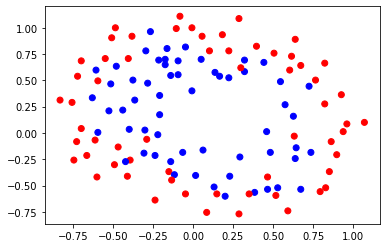

In [6]:
plot_data(X, Y)

In [38]:
cls = NeuralNet([4, 3, 3],normalize = True, learning_rate = 0.05, num_iter = 10000, epsilon = (10)^(-15), k = 100)

0-th iteration: 0.7926456103222955
1000-th iteration: 0.6917696677906687
2000-th iteration: 0.6895718433435729
3000-th iteration: 0.6840343951543074
4000-th iteration: 0.6648220905377901
5000-th iteration: 0.5745720662543327
6000-th iteration: 0.4039305928718137
7000-th iteration: 0.3541196668617229
8000-th iteration: 0.33899404790272575
9000-th iteration: 0.3260531686850619


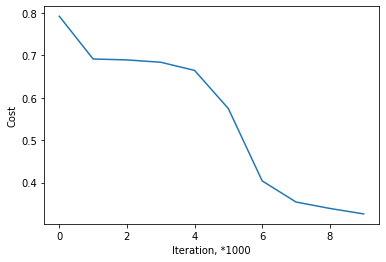

In [39]:
cls.fit(X, Y.reshape((df.shape[0], 1)))

In [40]:
print(cls.parameters)

{'W_1': array([[ 0.66907895,  1.40849881, -1.12052112,  0.82716457,  0.15241928],
       [-1.19283607, -1.52834279,  1.15036834,  1.07221581,  1.7623092 ],
       [ 0.12589616, -0.88070317, -1.57463109,  0.43903635, -2.14857893],
       [ 0.95291987, -0.31262538,  0.36740808,  2.05750111,  0.41069266]]), 'b_1': array([[-0.03441577],
       [-0.75154636],
       [ 0.89929597],
       [ 0.17623986]]), 'W_2': array([[-1.07933703e-02,  9.95462744e-01, -1.14744217e+00,
         7.56694496e-01],
       [ 1.90056108e+00, -3.63863816e+00,  2.29312660e+00,
        -1.71515404e+00],
       [-9.17642509e-01, -8.80843928e-02,  5.19021416e-04,
        -4.78566377e-01]]), 'b_2': array([[ 0.09064152],
       [ 0.16227179],
       [-0.08456602]]), 'W_3': array([[ 1.79205073, -2.78805952,  0.45076378],
       [ 0.40738291, -1.48122057,  0.8127961 ],
       [-1.12622952,  4.36618293,  0.18542454]]), 'b_3': array([[ 0.30049072],
       [ 0.22399377],
       [-1.57313198]]), 'W_4': array([[-3.75779154, -1

In [41]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.76316125],
       [0.89116922],
       [0.07903236],
       [0.1074587 ],
       [0.02532664],
       [0.91979279],
       [0.01984244],
       [0.05334373],
       [0.8680147 ],
       [0.93136801],
       [0.93296859],
       [0.24800495],
       [0.46780468],
       [0.07028369],
       [0.87979892],
       [0.01984933],
       [0.73576373],
       [0.85340036],
       [0.83567257],
       [0.02448158],
       [0.94252996],
       [0.91577152],
       [0.90430491],
       [0.03518462],
       [0.2373023 ],
       [0.80240062],
       [0.14901109],
       [0.32739392],
       [0.3620986 ],
       [0.89204998],
       [0.92724856],
       [0.69936077],
       [0.49513334],
       [0.92967863],
       [0.00983247],
       [0.75041807],
       [0.679624  ],
       [0.08647786],
       [0.94536571],
       [0.01817912],
       [0.02171042],
       [0.6739402 ],
       [0.01754249],
       [0.24672591],
       [0.0648511 ],
       [0.93027471],
       [0.02700627],
       [0.010

In [42]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0])

In [43]:
accuracy_score(Y, Y_hat)

0.847457627118644

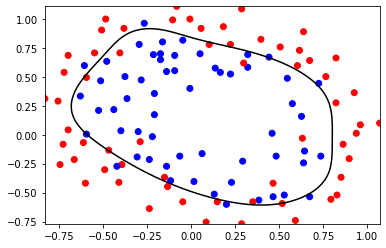

In [44]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [33]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'logistic')#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [34]:
Y = Y.reshape(Y.shape[0], )
clf.fit(X, Y)

MLPClassifier(activation='logistic', hidden_layer_sizes=(20,), max_iter=10000)

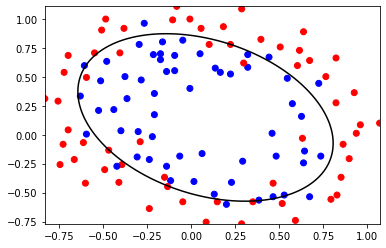

In [35]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [36]:
accuracy_score(Y, clf.predict(X))

0.8559322033898306

In [37]:
clf.n_iter_

1322